# Problem Statement

Much work on sentiment analysis has been done on short-form text data such as those derived from micro-blogging social media sites. Because of the succinct nature of these social media posts, it is perhaps easier to glean points of view than from longer pieces of text.
I would therefore like to perform sentiment parsing of long-form text in the form of book reviews. 


I will use book reviews scraped from various websites including Goodreads stored on Kaggle as CSV files. The goal is to use different machine learning models to parse sentiment (either positive or negative) from each review. For this supervised classification problem, I will compare the performance of a Long Short Term Memory neural network (in this notebook) and Recurrent Neural Network (notebook d.) to a Naive Bayes model (notebook b.)

In [1]:
from __future__ import print_function
%matplotlib inline

import datetime

import os

import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle

import spacy
import en_core_web_sm

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras import regularizers

from sklearn.model_selection import train_test_split

import re
import string

PROJ_ROOT = os.path.join(os.pardir, os.pardir)

In [2]:
path = '/Users/teresiahkahura/Desktop/ds/SB-Capstone2/data/processed/reviews5.pkl'
df = pd.read_pickle(path)

assert df.shape == (3268, 2)

# Preprocessing

I used a different suite of preprocessing tools from the Naive Bayes model in order to familiarize myself with TensorFlow implementation. Apart from using spaCy to lemmatize the text, I used Tensorflow's text tokenizer in this case instead of Count Vectorizer used in running the Naive Bayes Model.

In [3]:
# Using spacy to tokenize and lemmatize not including pronouns
nlp = en_core_web_sm.load()

def lemmatize_text(text):
    """Takes a corpus of text and tokenizes it in addition to lemmatizing
    
    """
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

In [4]:
df['text'] = [lemmatize_text(sent) for sent in df['text']]

In [5]:
#converting the label column to an array in preparation to feed into neural network
x = df["text"]
y = df["label"].values

In [6]:
#using Tensorflow's tokenizer to filter out special characters and digits
tokenizer = Tokenizer(lower=True, filters='\d*!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', split = ' ')
tokenizer.fit_on_texts(x)

In [7]:
def get_sequence_of_tokens(corpus):
    """
    Takes a corpus of text as argument and returns its input size which will be used in creating the 
    neural network first layer.
    Also returns a vector representation of the text. 
    """
    #getting the input size to encode in the neural networks first layer
    total_words = len(tokenizer.word_index) + 1
    
    #converts texts into vector space 
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        input_sequences.append(token_list)
    return input_sequences, total_words

inp_sequences, total_words = get_sequence_of_tokens(x)

In [8]:
def generate_padded_sequences(input_sequences):
    """
    Takes vectorized representation of text as argument and pads sequences that are smaller 
    to the size of the longest sequence length. 
    """
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len,))
   
    predictors = input_sequences[:,:-1]
    return predictors, max_sequence_len

predictors, max_sequence_len = generate_padded_sequences(inp_sequences)

In [9]:
# splits the vectorized representations of text and labels into test and training sizes
x_train, x_test, y_train, y_test = train_test_split(predictors, y, test_size=0.5, random_state=42)

The model performed best with an even split between the test and train sets perhaps due to the small size of the dataset. 

# Setting up LSTM


In [17]:
def build_model():
    """
    Builds layers of neural network.
    """
    opt = Adam(lr=0.001)
    model = tf.keras.Sequential()
    #establishes first embedding layer with the shape of the total_words variable and a batch size of 64
    model.add(tf.keras.layers.Embedding(total_words, 64))
    #The subsequent layers are bidirectional learning LSTM neural networks
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.7, recurrent_dropout=0.7, return_sequences=True)))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)))
    #Added regularization to minimize the effect of high dimensions sometimes present in sparse matrix data
    model.add(tf.keras.layers.Dense(6, kernel_regularizer = regularizers.l1_l2(l1=0.01, l2=0.01)))
    model.add(tf.keras.layers.Dropout(0.2))
    #The last layer has sigmoid activation function to convert predictions to 0 - 1 format 
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    #Added loss function optimized for binary labels
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.AUC()])
    
    return model

lstm_model = build_model()

In [18]:
#removes previous logs 
!rm -r /tmp/logs/

In [19]:
#saves the best performing model onto disk
logdir = os.path.join("/tmp/logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tb_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='/tmp/sentiment_analysis.hdf5', 
                                                  verbose = 1, 
                                                  save_best_only= True)

Fitting the model takes approximately 5 minutes on the local machine.

In [20]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=5)
history_lstm = lstm_model.fit(x_train, y_train, epochs = 5, validation_split = 0.1, 
                              callbacks = [tb_callback, checkpoint])

Epoch 1/5
46/46 [==============================] - ETA: 0s - loss: 1.2506 - accuracy: 0.5054 - auc: 0.5178
Epoch 00001: val_loss improved from inf to 1.13976, saving model to /tmp/sentiment_analysis.hdf5
46/46 [==============================] - 24s 513ms/step - loss: 1.2506 - accuracy: 0.5054 - auc: 0.5178 - val_loss: 1.1398 - val_accuracy: 0.6159 - val_auc: 0.7329
Epoch 2/5
46/46 [==============================] - ETA: 0s - loss: 0.9459 - accuracy: 0.7259 - auc: 0.7912
Epoch 00002: val_loss improved from 1.13976 to 0.83769, saving model to /tmp/sentiment_analysis.hdf5
46/46 [==============================] - 22s 474ms/step - loss: 0.9459 - accuracy: 0.7259 - auc: 0.7912 - val_loss: 0.8377 - val_accuracy: 0.7622 - val_auc: 0.8253
Epoch 3/5
46/46 [==============================] - ETA: 0s - loss: 0.6277 - accuracy: 0.8599 - auc: 0.9216
Epoch 00003: val_loss improved from 0.83769 to 0.73813, saving model to /tmp/sentiment_analysis.hdf5
46/46 [==============================] - 25s 553ms/s

A very helpful feature of neural networks is the ability to visualize when the model is about to introduce more variance in the error. The cell above shows the model begins to overfit around the fourth epoch when the accuracy jumps from 86 % to 92 % but validation accuracy decreases from 77% to 76%. 

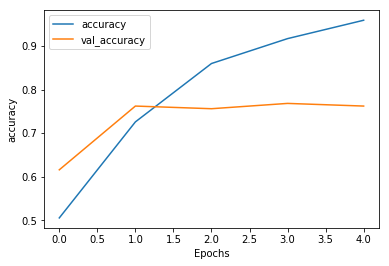

In [21]:
def plot_graphs(history, metric):
    """
    Takes a model and associated metric and plots performance over the specified epochs
    """
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+ metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+ metric])
    plt.show()

plot_graphs(history_lstm, 'accuracy')

The plot is a clearer visualization of the model's progressive overfitting around the third epoch. 

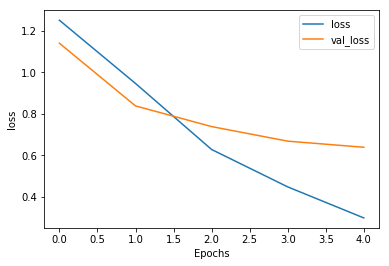

In [22]:
plot_graphs(history_lstm, 'loss')

The plot of the loss further confirms the model's overfitting. The validation loss curve's decrease is less starting from around the third epoch.

In [23]:
results = lstm_model.evaluate(x_test, y_test)
print(results)

52/52 [==============================] - 3s 64ms/step - loss: 0.6256 - accuracy: 0.7889 - auc: 0.8622
[0.6256128549575806, 0.7888616919517517, 0.8621546030044556]


This model's accuracy slightly outperforms the Bernoulli Naive Bayes classifier at 79% compared to 78%. The AUC in this neural networks clearly outstrips that of the Naive Bayes classifier suggesting that the neural network does a better job identifying true positives. 

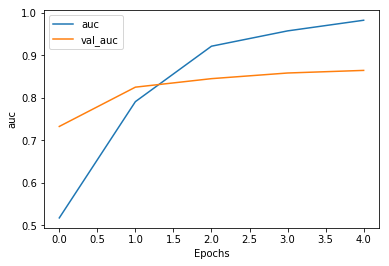

In [25]:
plot_graphs(history_lstm, 'auc')

# Conclusion 

During preprocessing, I discovered that my dataset had reviews in different languages including Spanish and Arabic and removing these resulted in a smaller corpus to train on. While the performance of our LSTM best model is decent, increased accuracy to distinguish positive sentiment can be achieved by training the model on more text. 